In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
pd.set_option('future.no_silent_downcasting', True)

In [3]:
path = "D:/downloads/Data Folder/[1] financial-literacy-data.csv"

In [4]:
path2 = "D:/downloads/Data Folder/reference-person-age-ranges-2023.xlsx"

In [5]:
lookup_df = pd.read_excel(path2, sheet_name="Table 1300")

In [6]:
lookup_df.head()

,Item,All\nconsumer\nunits,Under\n25\nyears,25-34\nyears,35-44\nyears,45-54\nyears,55-64\nyears,65 years\nand older,65-74\nyears,75 years\nand older
0,Number of consumer units (in thousands) a/,134556.00,6041,21082.00,23612.00,22721.00,23927.00,37173.00,21584.0,15589
1,Income after taxes b/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Mean,87869.00,51278,84939.00,109075.00,115653.00,97276.00,58969.00,65461.0,49981
3,SE,1229.83,3390.36,1876.44,2798.48,3149.06,4634.12,1741.27,2109.7,2256.34
4,Average annual expenditures,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [7]:
# Xóa dấu xuống dòng và từ "years", chuẩn hóa lại
lookup_df.columns = lookup_df.columns.str.replace('\n', ' ', regex=True)         # bỏ \n
lookup_df.columns = lookup_df.columns.str.replace('years', '', regex=False)      # bỏ chữ 'years'
lookup_df.columns = lookup_df.columns.str.strip()                                # bỏ khoảng trắng thừa
lookup_df.columns = lookup_df.columns.str.replace('and older', '+')              # đổi "and older" → "+"
lookup_df.columns = lookup_df.columns.str.replace('Under 25', 'Under 25')        # có thể giữ nguyên
lookup_df.rename(columns={"Under 25": "18–24"}, inplace=True)

In [8]:
lookup_df.columns

Index(['Item', 'All consumer units', '18–24', '25-34', '35-44', '45-54',
       '55-64', '65  +', '65-74', '75  +'],
      dtype='object')

In [9]:
# Chuyển 'c/', 'a/'... về NaN
lookup_df.replace(['c/', 'a/', 'b/'], np.nan, inplace=True)

In [10]:
# Xóa theo tên cột
lookup_df.drop(columns=["65  +","65-74", "75  +"], inplace=True)

In [11]:
# Gán thủ công tên nhóm tuổi từ dòng đầu (cột 1 trở đi)
age_groups = [
    "All",
    "18-25",
    "26-35",
    "36-45",
    "46-55",
    "56-65",
]

# Tách dữ liệu theo cụm: [Tên dòng], Mean, SE
records = []
i = 1
while i < len(lookup_df):
    row_name = lookup_df.iloc[i, 0]

    if row_name == "Mean":
        category = lookup_df.iloc[i - 1, 0]

        # Bỏ dòng bị NaN (ví dụ: 'Income after taxes b/')
        if pd.isna(category):
            i += 2
            continue

        mean_values = lookup_df.iloc[i, 1:10].tolist()
        se_values = lookup_df.iloc[i + 1, 1:10].tolist()

        for age, mean, se in zip(age_groups, mean_values, se_values):
            records.append({
                "Item": category,
                "Age_Group": age,
                "Mean": mean,
                "SE": se
            })
        i += 2
    else:
        i += 1

# Tạo DataFrame sạch
df_cleaned = pd.DataFrame(records)

# Lưu lại nếu muốn
# df_cleaned.to_csv("bls_table1300_cleaned.csv", index=False)

# Xem trước vài dòng
print(df_cleaned.head(15))

                           Item Age_Group      Mean       SE
0         Income after taxes b/       All   87869.0  1229.83
1         Income after taxes b/     18-25   51278.0  3390.36
2         Income after taxes b/     26-35   84939.0  1876.44
3         Income after taxes b/     36-45  109075.0  2798.48
4         Income after taxes b/     46-55  115653.0  3149.06
5         Income after taxes b/     56-65   97276.0  4634.12
6   Average annual expenditures       All   77280.0   994.16
7   Average annual expenditures     18-25   49560.0  2555.44
8   Average annual expenditures     26-35   71867.0  1601.18
9   Average annual expenditures     36-45   90939.0  2781.44
10  Average annual expenditures     46-55   97319.0  2275.56
11  Average annual expenditures     56-65   83379.0  1921.17
12                         Food       All    9985.0   122.90
13                         Food     18-25    5953.0   362.59
14                         Food     26-35    9704.0   286.51


In [12]:
# Mapping từ tên dòng BLS sang tên cột trong dataset gốc của bạn
bls_to_original_column = {
    "Income after taxes b/": "Income",
    "Food": "Food",
    "Average annual expenditures": "Total Spending",
    "Food at home": "Food at home",
    "Food away from home": "Eating_Out",
    "Rented dwellings": "Rent",
    "Utilities, fuels, and public services": "Utilities",
    "Healthcare": "Healthcare",
    "Entertainment": "Entertainment",
    "Education": "Education",
    "Miscellaneous": "Miscellaneous",
    "Personal insurance and pensions": "Insurance",
    "Transportation": "Transport"
}

# Tạo cột 'Mapped_Column' để ánh xạ dòng BLS sang cột gốc
df_cleaned["Mapped_Column"] = df_cleaned["Item"].map(bls_to_original_column)

# Chỉ giữ lại các dòng có ánh xạ thành công
df_items_mapped = df_cleaned[df_cleaned["Mapped_Column"].notna()].copy()

df_items_mapped.head(10)


,Item,Age_Group,Mean,SE,Mapped_Column
0,Income after taxes b/,All,87869.0,1229.83,Income
1,Income after taxes b/,18-25,51278.0,3390.36,Income
2,Income after taxes b/,26-35,84939.0,1876.44,Income
3,Income after taxes b/,36-45,109075.0,2798.48,Income
4,Income after taxes b/,46-55,115653.0,3149.06,Income
5,Income after taxes b/,56-65,97276.0,4634.12,Income
6,Average annual expenditures,All,77280.0,994.16,Total Spending
7,Average annual expenditures,18-25,49560.0,2555.44,Total Spending
8,Average annual expenditures,26-35,71867.0,1601.18,Total Spending
9,Average annual expenditures,36-45,90939.0,2781.44,Total Spending


In [13]:
# Filter out 'All' rows
df_filtered = df_items_mapped[df_cleaned["Age_Group"] != "All"]

# Pivot the table to wide format
df_pivot = df_filtered.pivot(index="Age_Group", columns="Mapped_Column", values="Mean")

# Clean column names
df_pivot.columns = df_pivot.columns.str.strip().str.replace(" ", "_").str.replace("/", "").str.lower()

# Convert index to categorical order
age_order = ["18-25", "26-35", "36-45", "46-55", "56-65"]
df_pivot = df_pivot.loc[age_order]
df_pivot.columns.name = None
df_pivot = df_pivot.reset_index()

In [14]:
df_pivot

,Age_Group,eating_out,education,entertainment,food,food_at_home,healthcare,income,insurance,miscellaneous,rent,total_spending,transport,utilities
0,18-25,2804.0,NaN,1835.0,5953.0,3149.0,1723.0,51278.0,5089.0,481.0,9831.0,49560.0,10699.0,2617.0
1,26-35,4167.0,1118.0,3008.0,9704.0,5537.0,3532.0,84939.0,10281.0,970.0,9293.0,71867.0,12879.0,3787.0
2,36-45,4795.0,1732.0,4694.0,12006.0,7211.0,5509.0,109075.0,13220.0,1308.0,6463.0,90939.0,15326.0,5035.0
3,46-55,5302.0,3193.0,4530.0,12941.0,7639.0,6338.0,115653.0,14879.0,1363.0,4936.0,97319.0,17311.0,5481.0
4,56-65,3744.0,2028.0,3899.0,10069.0,6324.0,7164.0,97276.0,11131.0,1466.0,3366.0,83379.0,14443.0,5147.0


In [15]:
correlation_matrix = df_pivot.select_dtypes(include='number').corr()
correlation_matrix.info()

<class 'pandas.core.frame.DataFrame'>
Index: 13 entries, eating_out to utilities
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   eating_out      13 non-null     float64
 1   education       13 non-null     float64
 2   entertainment   13 non-null     float64
 3   food            13 non-null     float64
 4   food_at_home    13 non-null     float64
 5   healthcare      13 non-null     float64
 6   income          13 non-null     float64
 7   insurance       13 non-null     float64
 8   miscellaneous   13 non-null     float64
 9   rent            13 non-null     float64
 10  total_spending  13 non-null     float64
 11  transport       13 non-null     float64
 12  utilities       13 non-null     float64
dtypes: float64(13)
memory usage: 2.0+ KB


In [16]:
correlation_matrix

,eating_out,education,entertainment,food,food_at_home,healthcare,income,insurance,miscellaneous,rent,total_spending,transport,utilities
eating_out,1.000000,0.641911,0.879918,0.970445,0.930511,0.632162,0.926139,0.960981,0.722155,-0.467920,0.917721,0.923866,0.813506
education,0.641911,1.000000,0.659479,0.778993,0.817378,0.681476,0.829829,0.844010,0.660592,-0.663226,0.860506,0.937423,0.851180
entertainment,0.879918,0.659479,1.000000,0.960767,0.980964,0.868766,0.981507,0.959684,0.920384,-0.757152,0.982683,0.941823,0.961707
food,0.970445,0.778993,0.960767,1.000000,0.991397,0.793707,0.989747,0.998340,0.865806,-0.648216,0.984938,0.966172,0.925480
food_at_home,0.930511,0.817378,0.980964,0.991397,1.000000,0.861762,0.999866,0.994008,0.922384,-0.730023,0.997133,0.965311,0.963411
healthcare,0.632162,0.681476,0.868766,0.793707,0.861762,1.000000,0.869265,0.820068,0.981439,-0.967146,0.883160,0.843347,0.962598
income,0.926139,0.829829,0.981507,0.989747,0.999866,0.869265,1.000000,0.993138,0.927009,-0.740857,0.998085,0.967219,0.967567
insurance,0.960981,0.844010,0.959684,0.998340,0.994008,0.820068,0.993138,1.000000,0.884769,-0.681493,0.989958,0.973303,0.940194
miscellaneous,0.722155,0.660592,0.920384,0.865806,0.922384,0.981439,0.927009,0.884769,1.000000,-0.901278,0.930116,0.868513,0.977767
rent,-0.467920,-0.663226,-0.757152,-0.648216,-0.730023,-0.967146,-0.740857,-0.681493,-0.901278,1.000000,-0.768174,-0.754580,-0.886477


In [17]:
# Dùng pandas để chuyển cột 'Mean' sang float
df_cleaned["Mean"] = pd.to_numeric(df_cleaned["Mean"], errors="coerce")
df_cleaned["SE"] = pd.to_numeric(df_cleaned["SE"], errors="coerce")

In [18]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Item           78 non-null     object 
 1   Age_Group      78 non-null     object 
 2   Mean           77 non-null     float64
 3   SE             77 non-null     float64
 4   Mapped_Column  78 non-null     object 
dtypes: float64(2), object(3)
memory usage: 3.2+ KB


In [20]:
df = pd.read_csv(path)

In [21]:
df.columns

Index(['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent',
       'Loan_Repayment', 'Insurance', 'Groceries', 'Transport', 'Eating_Out',
       'Entertainment', 'Utilities', 'Healthcare', 'Education',
       'Miscellaneous', 'Desired_Savings_Percentage', 'Desired_Savings',
       'Disposable_Income', 'Potential_Savings_Groceries',
       'Potential_Savings_Transport', 'Potential_Savings_Eating_Out',
       'Potential_Savings_Entertainment', 'Potential_Savings_Utilities',
       'Potential_Savings_Healthcare', 'Potential_Savings_Education',
       'Potential_Savings_Miscellaneous'],
      dtype='object')

In [22]:
# Thêm cột nhóm tuổi
bins = [17, 25, 35, 45, 55, 65]
labels = ['18-25', '26-35', '36-45', '46-55', '56-65']
df["Age_Group"] = pd.cut(df["Age"], bins=bins, labels=labels)

In [23]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78 entries, 0 to 77
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Item           78 non-null     object 
 1   Age_Group      78 non-null     object 
 2   Mean           77 non-null     float64
 3   SE             77 non-null     float64
 4   Mapped_Column  78 non-null     object 
dtypes: float64(2), object(3)
memory usage: 3.2+ KB


In [24]:
target_columns = [
    "Income", 
    "Total Spending",
    "Food",
    "Food at home",
    "Eating_Out",
    "Rent",
    "Utilities",
    "Healthcare",
    "Entertainment",
    "Education",
    "Miscellaneous",
    "Insurance",
    "Transport"
]

In [25]:
from scipy.linalg import eigh
import numpy as np
import pandas as pd

def nearest_psd(matrix):
    """Làm ma trận positive semi-definite bằng cách sửa eigenvalue âm."""
    matrix = (matrix + matrix.T) / 2
    eigval, eigvec = eigh(matrix)
    eigval[eigval < 0] = 0
    return eigvec @ np.diag(eigval) @ eigvec.T


def generate_synthetic_data_by_agegroup(df_base, df_lookup, corr_matrix, target_columns, group_col='Age_Group', default_n=100):
    """
    Sinh dữ liệu lognormal multivariate theo nhóm tuổi và correlation. Gán trực tiếp vào df_base.

    Args:
        df_base (DataFrame): Bảng gốc (sẽ được chỉnh trực tiếp)
        df_lookup (DataFrame): Bảng lookup có Mean, SE, Mapped_Column
        corr_matrix (DataFrame): Ma trận tương quan đã chuẩn hóa tên cột
        target_columns (list): Tên cột gốc cần sinh (có viết hoa, khoảng trắng)
        group_col (str): Cột nhóm (Age_Group)
        default_n (int): Giá trị mặc định nếu không có trong map
    """
    age_group_n_map = {
        "18-25": 134556,
        "26-35": 6041,
        "36-45": 21082,
        "46-55": 23612,
        "56-65": 23927,
        "65+": 37173
    }

    # Chuẩn hóa tên cho correlation_matrix tra cứu
    normalized_columns = [col.strip().lower().replace(" ", "_") for col in target_columns]

    for age_group in df_base[group_col].unique():
        n_rows = df_base[df_base[group_col] == age_group].shape[0]
        stats_rows = df_lookup[df_lookup["Age_Group"] == age_group]

        means, stds = [], []

        for norm_col in normalized_columns:
            row = stats_rows[stats_rows["Mapped_Column"] == norm_col]
            if not row.empty and pd.notna(row["Mean"].values[0]) and pd.notna(row["SE"].values[0]):
                mean = row["Mean"].values[0]
                se = row["SE"].values[0]
            else:
                mean = 100  # fallback
                se = 10

            std = se * np.sqrt(age_group_n_map.get(age_group, default_n))
            if np.isnan(std) or std <= 0:
                std = 1e-3

            means.append(mean)
            stds.append(std)

        # Covariance trong log-space
        means = np.array(means)
        stds = np.array(stds)
        sub_corr = corr_matrix.loc[normalized_columns, normalized_columns].values

        log_means = np.log(means**2 / np.sqrt(stds**2 + means**2))
        log_stds = np.sqrt(np.log(1 + (stds**2 / means**2)))
        log_cov = np.diag(log_stds) @ sub_corr @ np.diag(log_stds)
        log_cov = nearest_psd(log_cov)

        # Sinh log-data
        log_data = np.random.multivariate_normal(mean=log_means, cov=log_cov, size=n_rows)
        synthetic_data = np.exp(log_data)
        
         # ✅ Giới hạn upper bound để tránh đuôi dài
        for i, col in enumerate(target_columns):
            # Lấy mean thực tế từng biến để làm chuẩn
            upper_cap = means[i] * 10   # hoặc 5 nếu muốn chặt hơn
            synthetic_data[:, i] = np.clip(synthetic_data[:, i], 0, upper_cap)
        
        # Gán lại vào df_base theo tên cột gốc
        idx = df_base[group_col] == age_group
        for i, col in enumerate(target_columns):
            df_base.loc[idx, col] = synthetic_data[:, i]


In [26]:
# Tên gốc viết hoa, có dấu cách
target_columns = [
    "Income", "Total Spending", "Food", "Food at home", "Eating_Out",
    "Rent", "Utilities", "Healthcare", "Entertainment", "Education",
    "Miscellaneous", "Insurance", "Transport"
]

# Nhớ chuẩn hóa Mapped_Column và corr_matrix
df_cleaned["Mapped_Column"] = df_cleaned["Mapped_Column"].str.strip().str.lower().str.replace(" ", "_")
correlation_matrix.columns = correlation_matrix.columns.str.lower().str.replace(" ", "_")
correlation_matrix.index = correlation_matrix.index.str.lower().str.replace(" ", "_")

# Gọi sinh dữ liệu
generate_synthetic_data_by_agegroup(
    df_base=df,
    df_lookup=df_cleaned,
    corr_matrix=correlation_matrix,
    target_columns=target_columns  # tên gốc
)


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 31 columns):
 #   Column                           Non-Null Count  Dtype   
---  ------                           --------------  -----   
 0   Income                           20000 non-null  float64 
 1   Age                              20000 non-null  int64   
 2   Dependents                       20000 non-null  int64   
 3   Occupation                       20000 non-null  object  
 4   City_Tier                        20000 non-null  object  
 5   Rent                             20000 non-null  float64 
 6   Loan_Repayment                   20000 non-null  float64 
 7   Insurance                        20000 non-null  float64 
 8   Groceries                        20000 non-null  float64 
 9   Transport                        20000 non-null  float64 
 10  Eating_Out                       20000 non-null  float64 
 11  Entertainment                    20000 non-null  float64 
 12  Util

C:\Users\hoang\AppData\Local\Temp\ipykernel_7500\2391901729.py:5: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


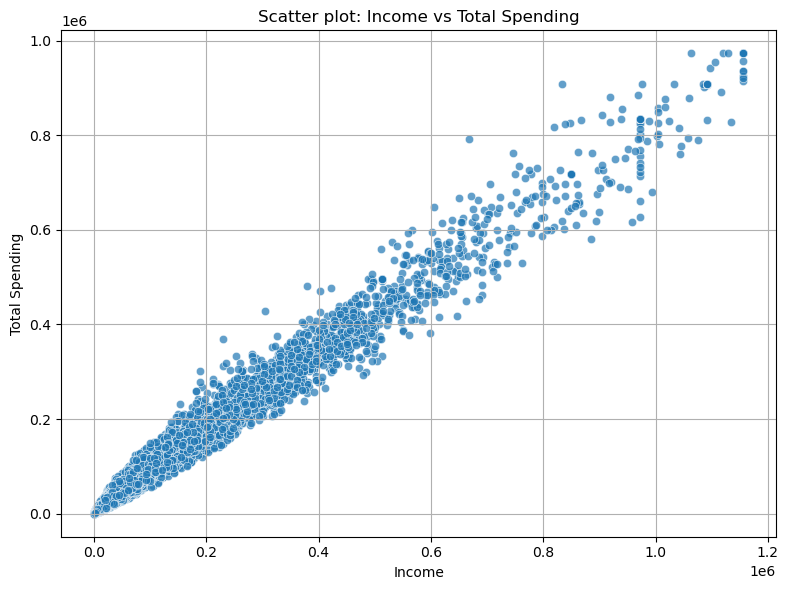

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=df,
    x="Income",
    y="Total Spending",
    # hue="Age_Group",  # nếu bạn có cột này
    palette="viridis",
    alpha=0.7
)

plt.title("Scatter plot: Income vs Total Spending")
plt.xlabel("Income")
plt.ylabel("Total Spending")
plt.grid(True)
plt.tight_layout()
plt.show()


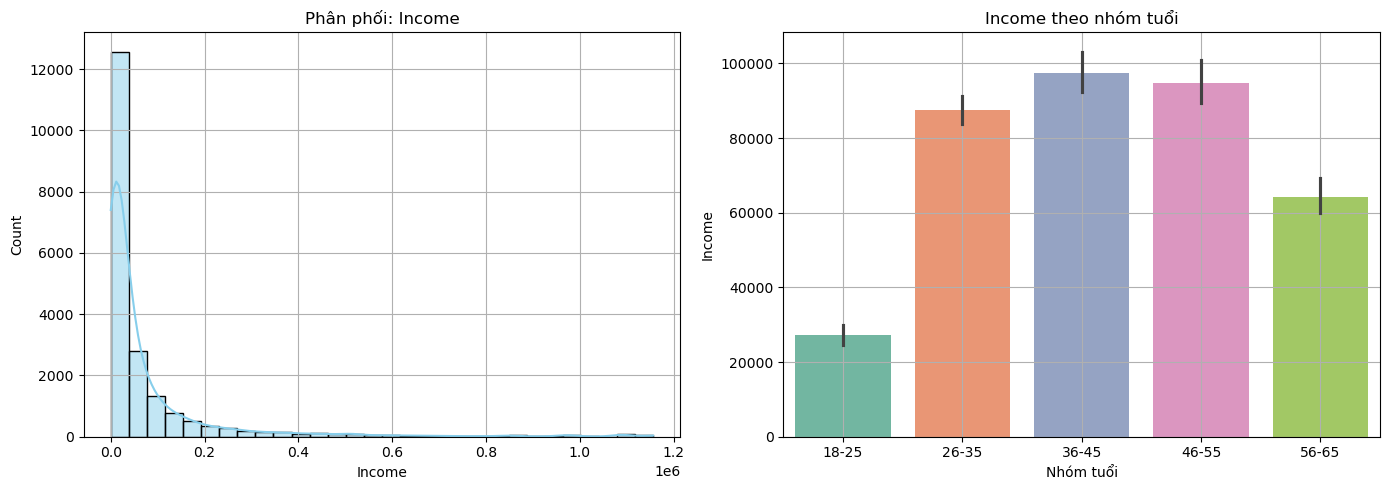

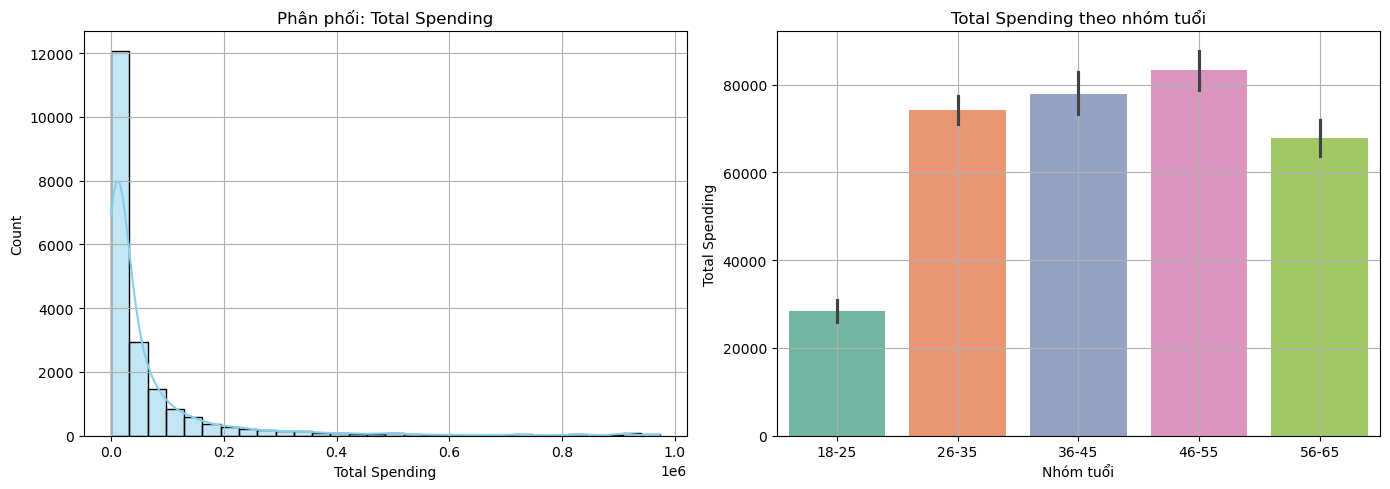

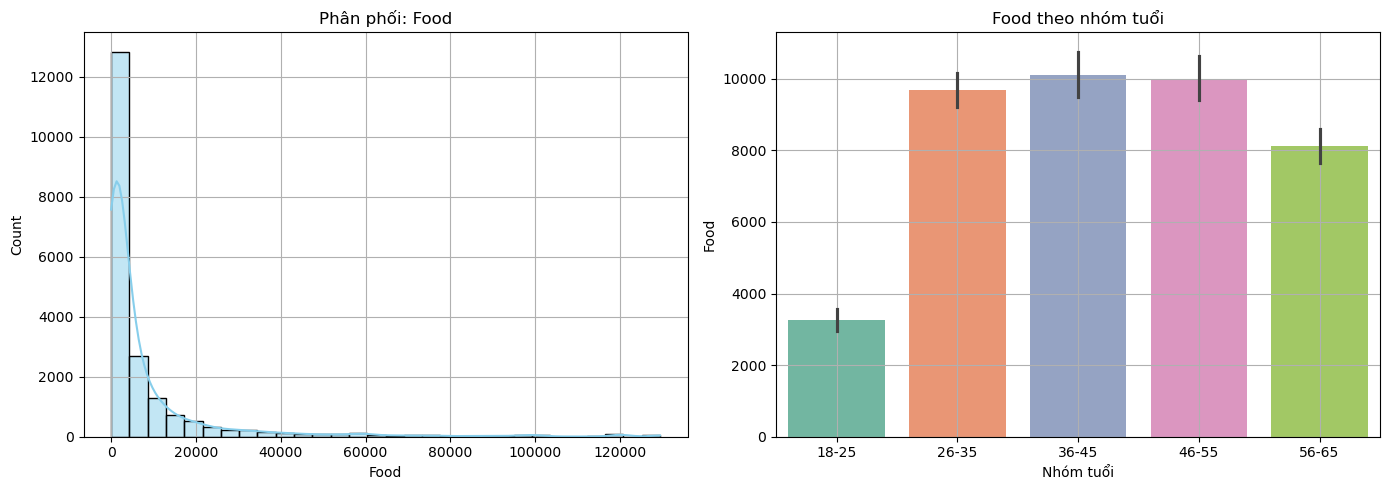

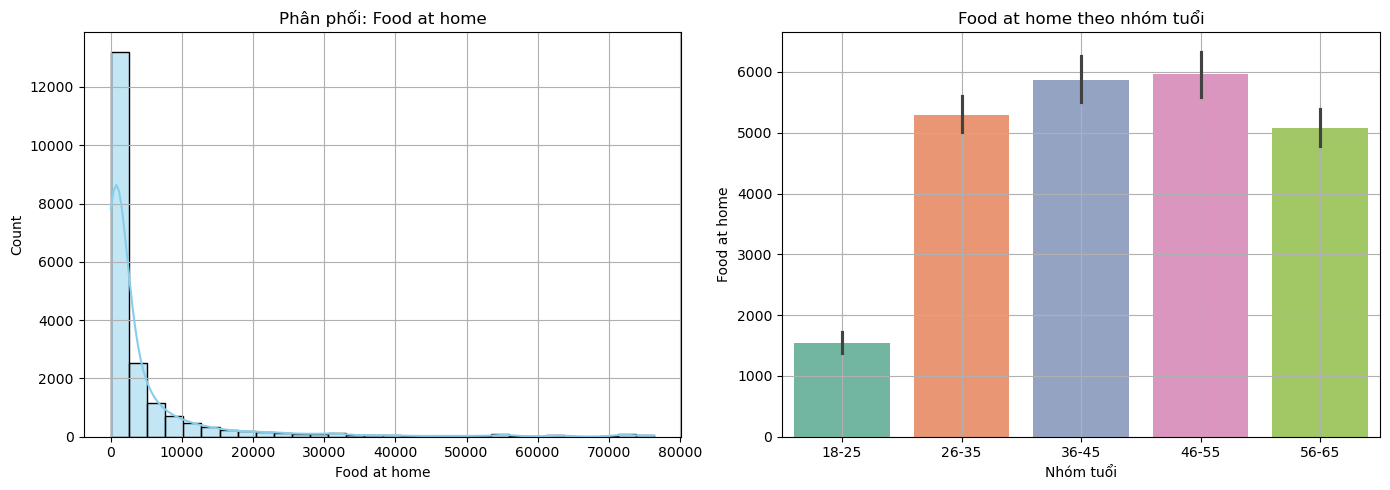

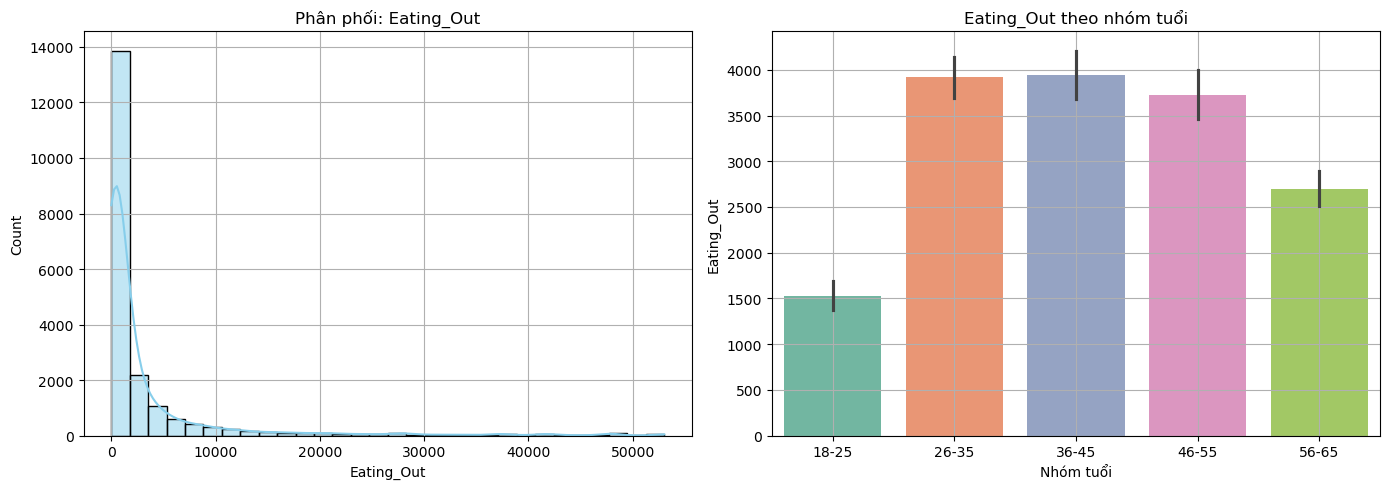

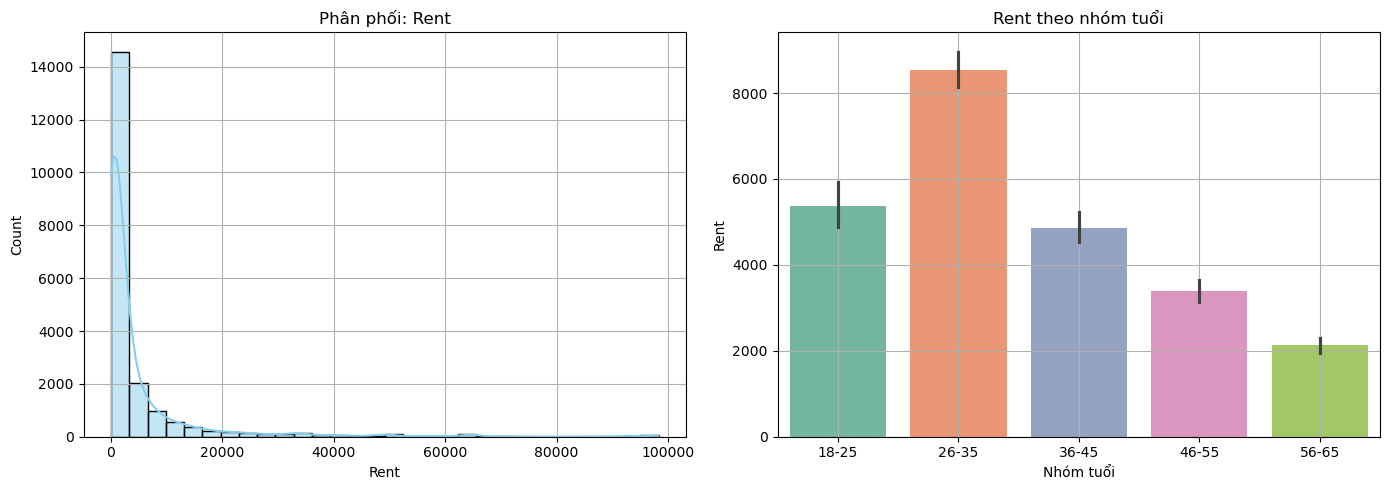

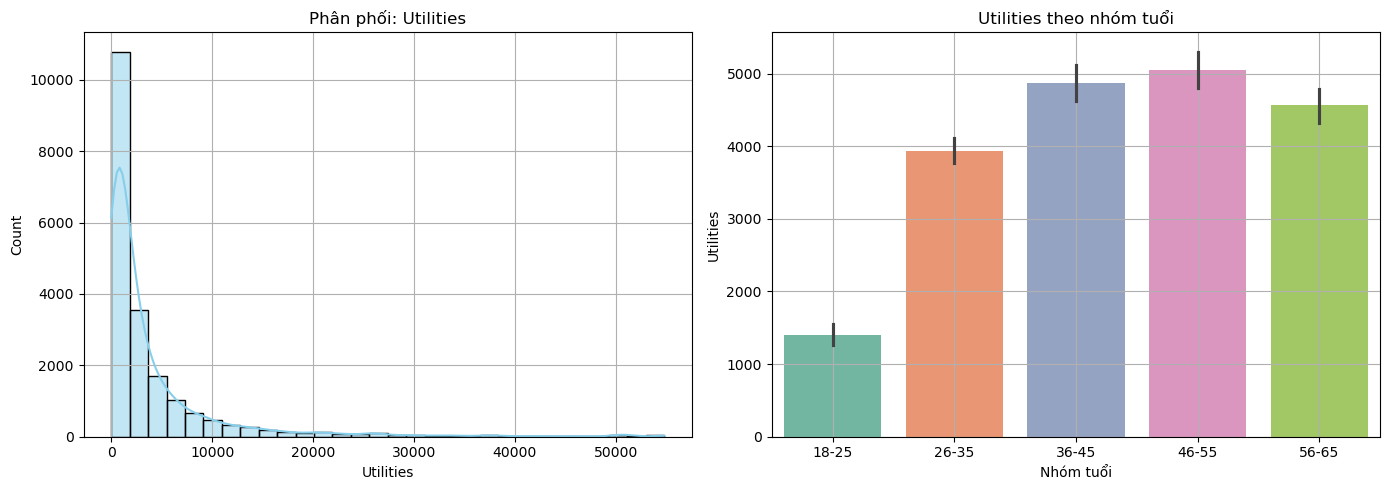

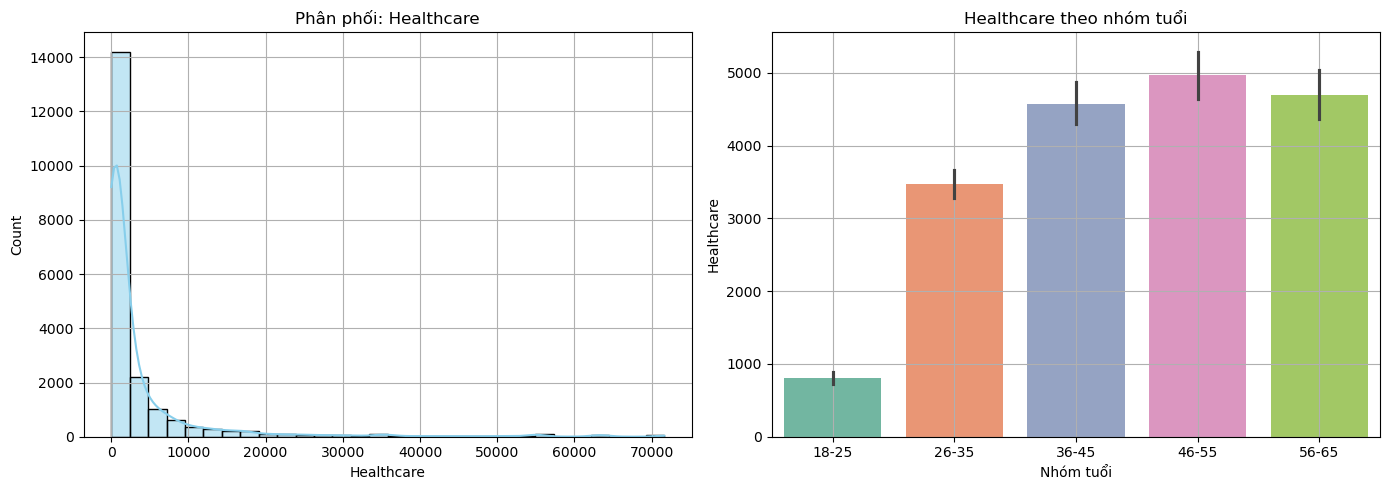

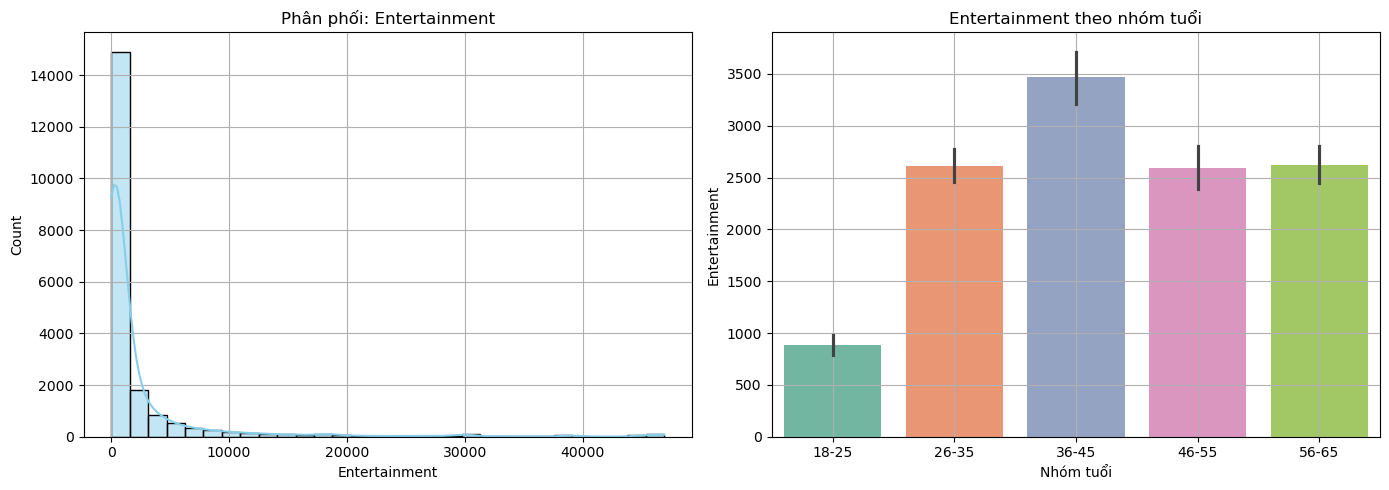

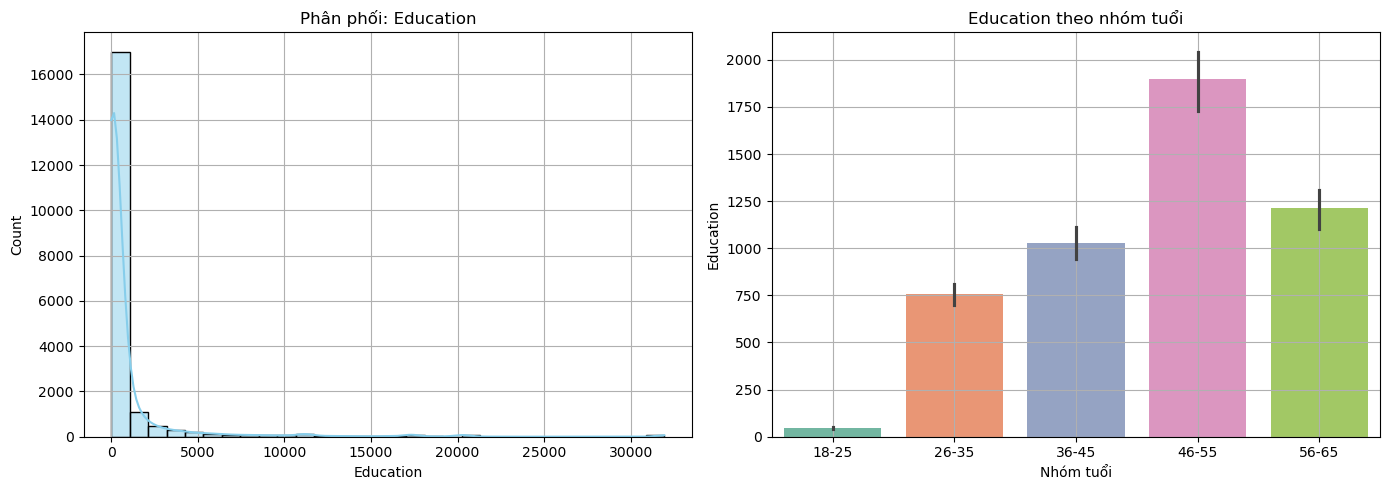

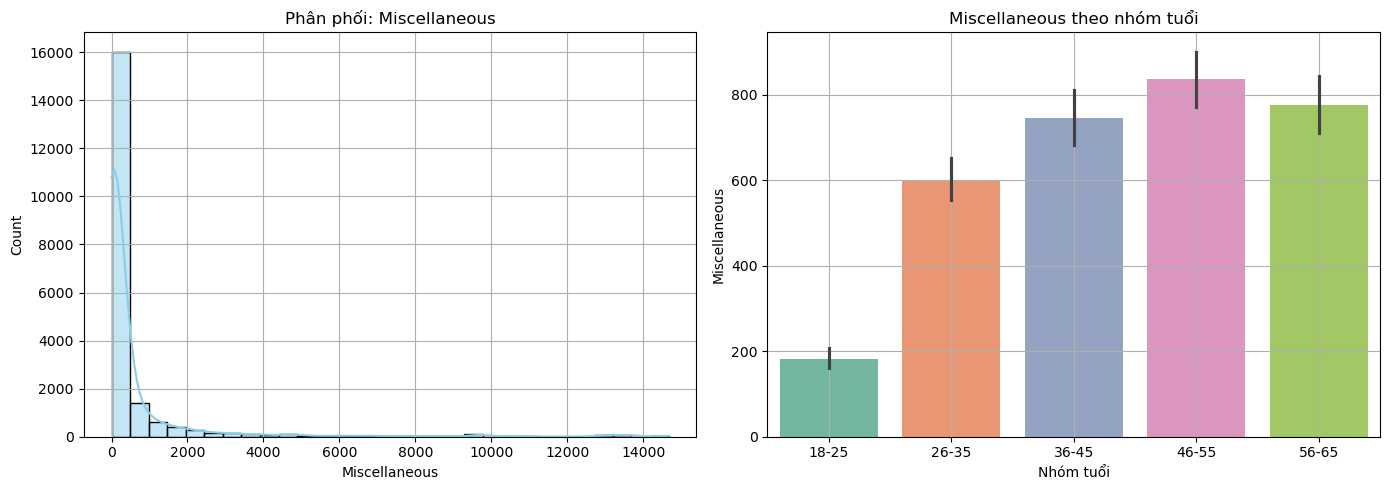

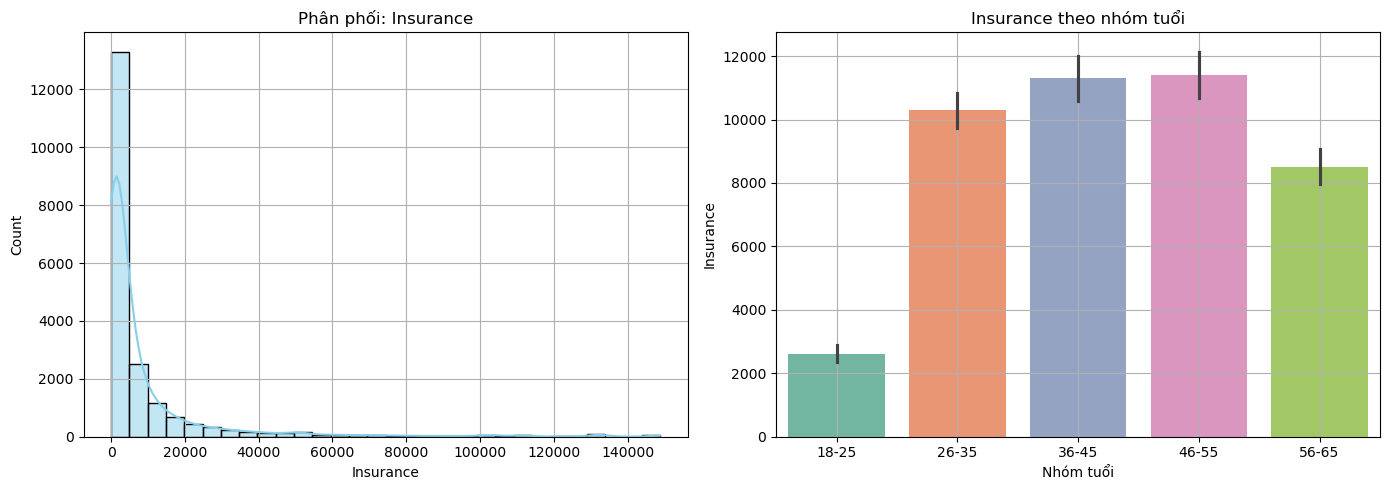

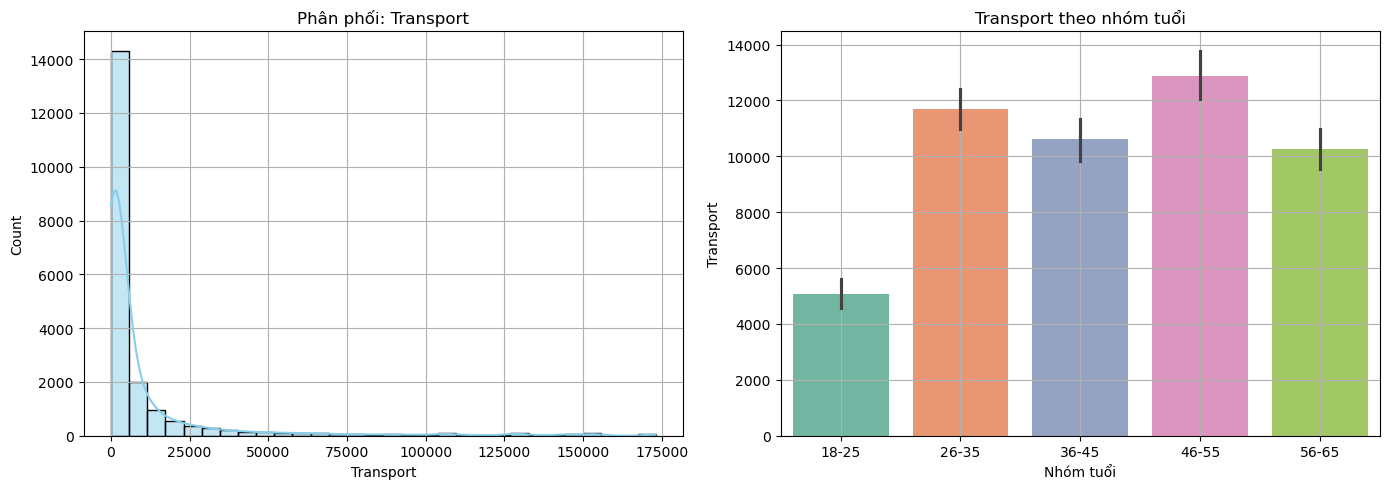

CPU times: total: 26.8 s
Wall time: 8.36 s


In [29]:
%%time
# Danh sách các biến cần vẽ
variables = target_columns

# Lặp qua từng biến để vẽ histogram và barplot
for var in variables:
    plt.figure(figsize=(14, 5))
    
    # Histogram - Phân phối toàn bộ
    plt.subplot(1, 2, 1)
    sns.histplot(data=df, x=var, kde=True, bins=30, color='skyblue')
    plt.title(f"Phân phối: {var}")
    plt.xlabel(var)
    plt.grid(True)

    # Barplot - Trung bình theo nhóm tuổi
    plt.subplot(1, 2, 2)
    if df[var].dtype != 'O':  # Nếu không phải kiểu object
        sns.barplot(data=df, x='Age_Group', y=var, hue='Age_Group', legend=False, palette='Set2')
        plt.title(f"{var} theo nhóm tuổi")
        plt.xlabel("Nhóm tuổi")
        plt.ylabel(var)
        plt.grid(True)
    
    plt.tight_layout()
    plt.show()


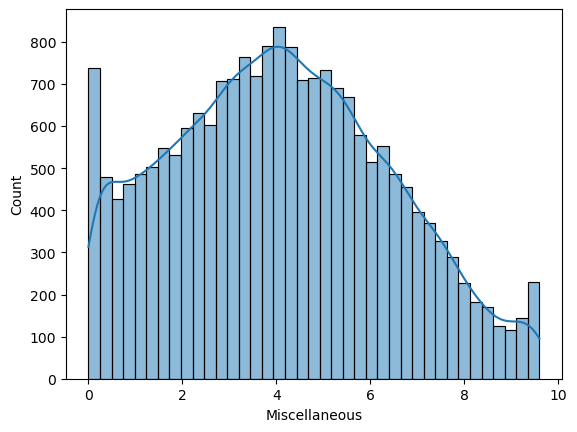

In [30]:
sns.histplot(np.log1p(df['Miscellaneous']), kde=True)
plt.show()

In [31]:
df.describe()

,Income,Age,Dependents,Rent,Loan_Repayment,Insurance,Groceries,Transport,Eating_Out,Entertainment,...,Potential_Savings_Transport,Potential_Savings_Eating_Out,Potential_Savings_Entertainment,Potential_Savings_Utilities,Potential_Savings_Healthcare,Potential_Savings_Education,Potential_Savings_Miscellaneous,Total Spending,Food,Food at home
count,2.000000e+04,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,...,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000,20000.000000
mean,7.627859e+04,41.031450,1.995950,4872.620879,2049.800292,9068.500297,5205.667493,10284.912126,3231.497091,2494.865197,...,473.042650,254.963280,254.031058,436.332808,41.524964,62.417083,144.904987,67780.202833,8417.019230,4868.094564
std,1.572012e+05,13.578725,1.417616,11691.852451,4281.789941,19610.517364,5035.953689,24649.194810,7415.791267,6457.749686,...,537.222853,296.047943,299.973590,503.200658,53.152458,98.842656,169.160951,133196.819229,17621.821742,10596.512495
min,4.679533e-01,18.000000,0.000000,0.052678,0.000000,0.032137,154.078240,0.019425,0.014131,0.003401,...,8.268076,3.797926,3.121610,6.200297,0.001238,0.000000,2.091973,0.708929,0.080325,0.015541
25%,5.304687e+03,29.000000,1.000000,181.608557,0.000000,548.155380,2165.426419,378.899452,148.429815,74.630835,...,161.913751,84.506870,84.562090,148.013618,11.037421,4.926210,47.637307,5870.339935,588.711898,289.299416
50%,2.137652e+04,41.000000,2.000000,893.114616,0.000000,2231.410127,3741.091535,1718.133660,645.937918,362.186664,...,307.045856,164.927660,164.740232,285.739582,25.202124,33.127987,93.090257,20900.144571,2234.624406,1151.527611
75%,6.966678e+04,53.000000,3.000000,3759.674636,2627.142320,7749.782576,6470.892718,7207.686729,2439.799041,1616.264012,...,588.419602,313.398240,310.927935,538.983703,52.353736,80.946145,178.257981,64710.360273,7479.256064,4080.307929
max,1.156530e+06,64.000000,4.000000,98310.000000,123080.682009,148790.000000,119816.898124,173110.000000,53020.000000,46940.000000,...,12273.258242,5573.036433,6222.200913,8081.799518,1394.531049,3647.244243,4637.951137,973190.000000,129410.000000,76390.000000


In [32]:
df.columns

Index(['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent',
       'Loan_Repayment', 'Insurance', 'Groceries', 'Transport', 'Eating_Out',
       'Entertainment', 'Utilities', 'Healthcare', 'Education',
       'Miscellaneous', 'Desired_Savings_Percentage', 'Desired_Savings',
       'Disposable_Income', 'Potential_Savings_Groceries',
       'Potential_Savings_Transport', 'Potential_Savings_Eating_Out',
       'Potential_Savings_Entertainment', 'Potential_Savings_Utilities',
       'Potential_Savings_Healthcare', 'Potential_Savings_Education',
       'Potential_Savings_Miscellaneous', 'Age_Group', 'Total Spending',
       'Food', 'Food at home'],
      dtype='object')

In [33]:
df.drop(columns = ['Loan_Repayment','Groceries','Desired_Savings_Percentage', 'Desired_Savings',
       'Disposable_Income', 'Potential_Savings_Groceries',
       'Potential_Savings_Transport', 'Potential_Savings_Eating_Out',
       'Potential_Savings_Entertainment', 'Potential_Savings_Utilities',
       'Potential_Savings_Healthcare', 'Potential_Savings_Education',
       'Potential_Savings_Miscellaneous'], inplace= True)

In [34]:
df.columns

Index(['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent',
       'Insurance', 'Transport', 'Eating_Out', 'Entertainment', 'Utilities',
       'Healthcare', 'Education', 'Miscellaneous', 'Age_Group',
       'Total Spending', 'Food', 'Food at home'],
      dtype='object')

In [35]:
cols = df.columns.tolist()

# Cột cần chuyển
to_move = ["Age_Group", "Total Spending"]

# Các cột còn lại (ngoại trừ những cột sẽ chuyển)
remaining_cols = [col for col in cols if col not in to_move]
new_order = remaining_cols + to_move

# Áp dụng lại
df = df[new_order]


In [36]:
df.columns

Index(['Income', 'Age', 'Dependents', 'Occupation', 'City_Tier', 'Rent',
       'Insurance', 'Transport', 'Eating_Out', 'Entertainment', 'Utilities',
       'Healthcare', 'Education', 'Miscellaneous', 'Food', 'Food at home',
       'Age_Group', 'Total Spending'],
      dtype='object')

In [37]:
df

,Income,Age,Dependents,Occupation,City_Tier,Rent,Insurance,Transport,Eating_Out,Entertainment,Utilities,Healthcare,Education,Miscellaneous,Food,Food at home,Age_Group,Total Spending
0,3721.788682,49,0,Self_Employed,Tier_1,5418.626733,405.054928,525.534021,176.372027,15.912946,360.115852,106.014433,52.437820,4.336263,390.604276,183.636154,46-55,4296.056199
1,258480.042379,34,2,Retired,Tier_2,358.084465,30353.197673,33341.194860,15514.036088,16597.222221,12740.870451,19981.744742,238.495500,5924.419048,32427.297670,18351.693784,26-35,215851.745815
2,33280.266313,35,1,Student,Tier_3,27594.090699,4323.517112,2971.145680,2982.300399,244.404718,909.442910,231.896904,154.649723,4.192934,4374.441667,1245.305763,26-35,26943.396548
3,257.290615,21,0,Self_Employed,Tier_3,1303.080973,28.444609,62.157023,16.571213,2.183100,15.781325,7.679892,1.951017,0.505200,36.013909,10.381869,18-25,382.336005
4,9324.989688,52,4,Professional,Tier_2,5041.934723,932.575711,363.700033,306.616875,44.248423,613.692267,294.902185,20.091617,34.546056,907.524010,503.573801,46-55,7933.395209
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,3686.345906,51,4,Self_Employed,Tier_1,972.216732,309.394798,505.395746,102.367006,33.629694,536.480772,341.247976,23.825881,12.390305,315.015977,179.239536,46-55,4542.246160
19996,1323.688438,21,1,Student,Tier_2,89.201388,155.286606,853.724755,95.635899,16.437150,129.691560,86.147441,13.101192,3.959151,183.978226,55.793030,18-25,2241.802873
19997,44868.185237,30,1,Professional,Tier_2,3333.409379,3966.205010,3537.298701,1306.164987,1045.999615,2135.922535,1334.123270,88.579322,48.646993,4141.090329,1791.945249,26-35,39254.736226
19998,120662.919297,27,2,Professional,Tier_1,5358.705784,17032.239674,11184.755652,8324.087320,1497.579499,3601.601502,1732.061397,471.741801,164.933537,15832.736964,6759.794899,26-35,92934.495637


In [38]:
# Xuất ra file CSV
# df.to_csv("synthetic_data_output.csv", index=False)

In [39]:
print(df["Total Spending"].sum())

1355604056.6612263


In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   Income          20000 non-null  float64 
 1   Age             20000 non-null  int64   
 2   Dependents      20000 non-null  int64   
 3   Occupation      20000 non-null  object  
 4   City_Tier       20000 non-null  object  
 5   Rent            20000 non-null  float64 
 6   Insurance       20000 non-null  float64 
 7   Transport       20000 non-null  float64 
 8   Eating_Out      20000 non-null  float64 
 9   Entertainment   20000 non-null  float64 
 10  Utilities       20000 non-null  float64 
 11  Healthcare      20000 non-null  float64 
 12  Education       20000 non-null  float64 
 13  Miscellaneous   20000 non-null  float64 
 14  Food            20000 non-null  float64 
 15  Food at home    20000 non-null  float64 
 16  Age_Group       20000 non-null  category
 17  Total Spendi

##Ý nghĩa các cột dữ liệu

|Thông tin cá nhân và nhân khẩu học| |
|--|--|
|Income|Thu nhập hàng năm của cá nhân|
|Age|Tuổi của từng cá nhân|
|Dependents|Số lượng người phụ thuộc (ví dụ: con cái, người thân...)|
|Occupation|Nghề nghiệp của cá nhân (ví dụ: Student, Retired, Self_Employed...)|
|City_Tier|Mức độ phát triển của thành phố nơi cá nhân sinh sống (Tier_1, Tier_2, Tier_3)|

|Chi tiêu hàng năm||
|--|--|
|Rent|Chi phí thuê nhà|
|Loan_Repayment|Số tiền trả nợ vay|
|Insurance|Phí bảo hiểm|
|Groceries|Chi tiêu cho nhu yếu phẩm (thức ăn, sinh hoạt)|
|Transport|Chi tiêu cho đi lại|
|Eating_Out|Chi tiêu cho việc ăn ngoài|
|Entertainment|Chi tiêu cho giải trí|
|Utilities|Chi phí tiện ích (điện, nước, internet...)|
|Healthcare|Chi phí chăm sóc sức khỏe|
|Education|Chi phí giáo dục|
|Miscellaneous|Các khoản chi tiêu linh tinh khác|

|Thông tin về tiết kiệm||
|--|--|
|Desired_Savings_Percentage|Phần trăm thu nhập mà cá nhân muốn tiết kiệm|
|Desired_Savings|Giá trị tiết kiệm mà cá nhân mong muốn đạt được|
|Disposable_Income|Thu nhập khả dụng sau khi trừ các chi phí|

|Tiềm năng tiết kiệm từ từng hạng mục||
|--|--|
|Potential_Savings_Groceries|Khoản tiết kiệm tiềm năng từ nhu yếu phẩm|
|Potential_Savings_Transport|Khoản tiết kiệm tiềm năng từ đi lại|
|Potential_Savings_Eating_Out|Khoản tiết kiệm tiềm năng từ ăn ngoài|
|Potential_Savings_Entertainment|Khoản tiết kiệm tiềm năng từ giải trí|
|Potential_Savings_Utilities|Khoản tiết kiệm tiềm năng từ tiện ích|
|Potential_Savings_Healthcare|Khoản tiết kiệm tiềm năng từ chăm sóc sức khỏe|
|Potential_Savings_Education|Khoản tiết kiệm tiềm năng từ giáo dục|
|Potential_Savings_Miscellaneous|Khoản tiết kiệm tiềm năng từ các chi tiêu linh tinh khác|